In [1]:
import functools
import itertools
import cmath
import operator
import matplotlib.pyplot as plt
import numpy as np
import qiskit.quantum_info as qi
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.quantum_info import random_statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_city

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit import QuantumCircuit, Aer, transpile, assemble, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import gcd, sqrt, pi
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from qiskit.circuit import Gate
from qiskit.providers.aer.noise import NoiseModel

from qiskit.circuit            import ParameterVector
from qiskit.opflow             import StateFn, AerPauliExpectation, PauliExpectation, CircuitSampler
from qiskit.opflow             import X, Y, Z, I
from qiskit.opflow             import PauliOp, SummedOp, PauliSumOp
from qiskit.utils              import QuantumInstance
print("Imports Successful")

ModuleNotFoundError: No module named 'qiskit'

# **Question 2** Implement on IBM-Q digital simulations of the time-evolution of the two- and three-spin Heisenberg model, explaining what are the main differences in the two implementations.

**Implementation of the non interacting and interacting unitary evolution operator**

In [2]:
#h1 is the non interacting hamiltonian operating on n spins
def h1(qc, n, Bg, t):
    for i in range(n):
        qc.rz(Bg*t,i)

In [3]:
#h_int is the interacting hamiltonian between two spins
def h_int(qc, x, y, j, t, n):
    #ZZ
    qc.cx(x,y)
    qc.rz((2*j*t)/n,y)
    qc.cx(x,y)
    
    #YY
    qc.rx(pi/2,x)
    qc.rx(pi/2,y)
    qc.cx(x,y)
    qc.rz((2*j*t)/n,y)
    qc.cx(x,y)
    qc.rx(-pi/2,x)
    qc.rx(-pi/2,y)
    
    #XX
    qc.ry(pi/2,x)
    qc.ry(pi/2,y)
    qc.cx(x,y)
    qc.rz((2*j*t)/n,y)
    qc.cx(x,y)
    qc.ry(-pi/2,x)
    qc.ry(-pi/2,y)

**2-spins**

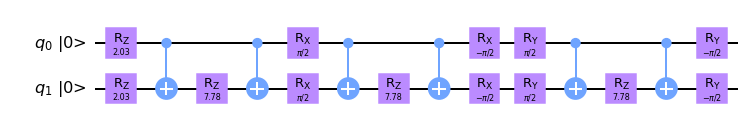

In [4]:
qc2 = QuantumCircuit(2)
h1(qc2, 2, Bg = np.random.uniform(0,2*pi), t=1)
h_int(qc2, 0,1, j = np.random.uniform(0,2*pi) , t=1, n=1)
qc2.draw('mpl', initial_state=True)

**3-spins**

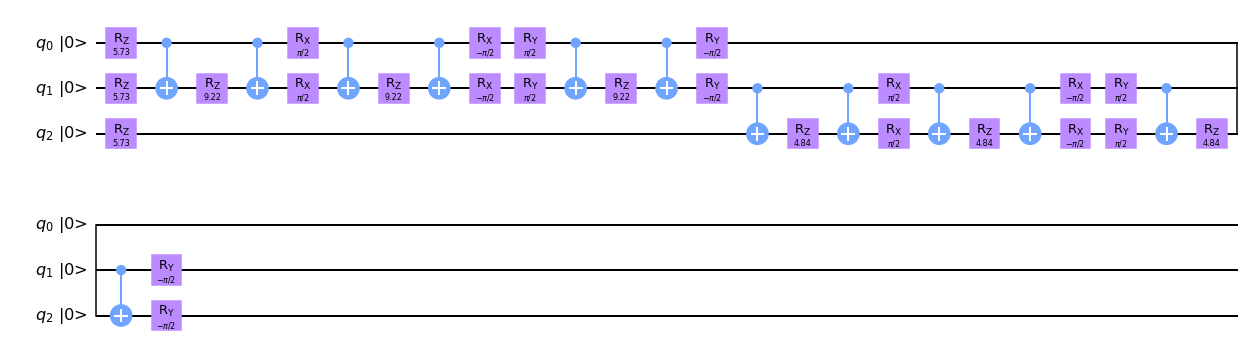

In [5]:
qc3 = QuantumCircuit(3)
h1(qc3, 3, Bg = np.random.uniform(0,2*pi), t=1)
h_int(qc3, 0,1, j = np.random.uniform(0,2*pi), t=1, n=1)
h_int(qc3, 1,2, j = np.random.uniform(0,2*pi), t=1, n=1)
qc3.draw('mpl', initial_state=True)

**3-spins with n Trotterization**

In [6]:
n=3

qc3_trot = QuantumCircuit(3)
h1(qc3, 3, Bg = np.random.uniform(0,2*pi), t=1)

for i in range(n):
    h_int(qc3, 0,1, j = np.random.uniform(0,2*pi), t=1, n=i+1)
    h_int(qc3, 1,2, j = np.random.uniform(0,2*pi), t=1, n=i+1)
    qc3_trot.barrier()

#qc3.draw('mpl', initial_state=True)

# Question 3: Using the QASM simulation, compute estimates of various observables of the system as a function of time, and in particular of the dynamical correlation functions.

In [7]:
backend1 = Aer.get_backend('qasm_simulator')
shots = 10000

# 2-spin observables

**2-spin correlation function of Pauli operators**

In [8]:
#Function that measures the correlation function of the Pauli Matrices on 2 qubits
def correlation_pauli_real_2spin(qc, Bg, j, t, v, w):
    
    qc.h(2)
    
    #W function
    if w == 'x':
        qc.cx(2, 0)
        qc.cx(2, 1)
    elif w == 'y':
        qc.cy(2, 0)
        qc.cy(2, 1)
    elif w == 'z':
        qc.cz(2, 0)
        qc.cz(2, 1)

    qc.x(2)
    qc.barrier()
    h1(qc, 2, Bg, t)
    h_int(qc, 0,1, j, t, n=1)
    qc.barrier()
    
    #V(t) function
    if v == 'x':
        qc.cx(2, 0)
        qc.cx(2, 1)
    elif v == 'y':
        qc.cy(2, 0)
        qc.cy(2, 1)
    elif v == 'z':
        qc.cz(2, 0)
        qc.cz(2, 1)
    
    qc.barrier()
    qc.x(2)
    
    #if real = True, measure the real part of the correlation function, if False the Imaginary
    qc.h(2)
    
    #ATTENTION ICI J'AI CHANGÉ DE L'ARTICLE!  ET AUSSI CELA MESURE - LA PARTIE IMAGINAIRE!
    
    #Now, measure the Real part of the correlation function
    qc.measure(2,0)
    results = execute(qc, backend=backend1, shots=shots).result()
    answer = results.get_counts()
    
    answer.setdefault('1')
    if answer['1'] is None:
        answer['1'] = 0
    
    answer.setdefault('0')
    if answer['0'] is None:
        answer['0'] = 0
    
    real = answer['0']/(answer['0']+answer['1'])*1 + answer['1']/(answer['0']+answer['1'])*(-1)
    
    return real

In [9]:
#Function that measures the correlation function of the Pauli Matrices on 2 qubits
def correlation_pauli_im_2spin(qc, Bg, j, t, v, w):
    
    qc.h(2)
    
    #W function
    if w == 'x':
        qc.cx(2, 0)
        qc.cx(2, 1)
    elif w == 'y':
        qc.cy(2, 0)
        qc.cy(2, 1)
    elif w == 'z':
        qc.cz(2, 0)
        qc.cz(2, 1)

    qc.x(2)
    qc.barrier()
    h1(qc, 2, Bg, t)
    h_int(qc, 0,1, j, t, n=1)
    qc.barrier()
    
    #V(t) function
    if v == 'x':
        qc.cx(2, 0)
        qc.cx(2, 1)
    elif v == 'y':
        qc.cy(2, 0)
        qc.cy(2, 1)
    elif v == 'z':
        qc.cz(2, 0)
        qc.cz(2, 1)
        
    qc.barrier()
    qc.x(2)
    
    #if real = True, measure the real part of the correlation function, if False the Imaginary
    qc.sdg(2)
    qc.h(2)
    
    #Now, measure the Real part of the correlation function
    qc.measure(2,0)
    results = execute(qc, backend=backend1, shots=shots).result()
    answer = results.get_counts()
    
    answer.setdefault('1')
    if answer['1'] is None:
        answer['1'] = 0
    
    answer.setdefault('0')
    if answer['0'] is None:
        answer['0'] = 0
    
    im = answer['0']/(answer['0']+answer['1'])*1 + answer['1']/(answer['0']+answer['1'])*(-1)
    
    return im
    
    #ATTENTION ICI J'AI CHANGÉ DE L'ARTICLE!  ET AUSSI CELA MESURE - LA PARTIE IMAGINAIRE!

**Measurement**

In [10]:
#CAREFUL CHANGE GROUND STATE IF WANT 
def corr_fct(Bg, j, t, v, w):
    #Real part of the correlation function
    qc_real = QuantumCircuit(3,1)

    #Initialisation to the ground state
    qc_real.h(1)
    
    real = correlation_pauli_real_2spin(qc_real, Bg, j, t, v, w)
    #qc_real.draw('mpl')
    
    #Imaginary part of the correlation function
    qc_im = QuantumCircuit(3,1)
    
    #Initialisation to the ground state
    qc_im.h(1)

    im = correlation_pauli_im_2spin(qc_im, Bg, j, t, v, w)
    #qc_im.draw('mpl')
    
    corr = z = complex(real,im)
    
    return corr

Verification

In [11]:
#qc = QuantumCircuit(3,1)
#qc.h(1)
#correlation_pauli_im_2spin(qc, 20, 1, 2, 'y', 'z')
#qc.draw('mpl')

Verification that it worked 

In [12]:
#results = execute(qc_real, backend=backend1, shots=shots).result()
#answer = results.get_counts()
#plot_histogram(data = answer, figsize=(8,5), color='cyan', title = 
#              'Results of the 2-spin measurement of the real part of the correlation function Cyx')

In [13]:
#results = execute(qc_im, backend=backend1, shots=shots).result()
#answer = results.get_counts()
#plot_histogram(data = answer, figsize=(8,5), color='cyan', title = 
#              'Results of the 2-spin measurement of the imaginary part of the correlation function Cyx')

**Magnetization**

In [14]:
#i the spin on which we want to measure the magnetization, j, t, Bg are the values needed for the Unitary hamiltonian
#CAREFUL THE GROUND STATE IS PUT HERE
def magnetization_2spin(i, Bg, j, t):
    qc_m = QuantumCircuit(2,1)
    qc_m.h(1)
    h1(qc_m, 2, Bg, t)
    h_int(qc_m, 0,1, j, t, n=1)
    qc_m.measure(i,0)
    results = execute(qc_m, backend=backend1, shots=shots).result()
    answer = results.get_counts()
    
    answer.setdefault('1')
    if answer['1'] is None:
        answer['1'] = 0
    
    answer.setdefault('0')
    if answer['0'] is None:
        answer['0'] = 0

    spin_magn = answer['0']/(answer['0']+answer['1'])*1 + answer['1']/(answer['0']+answer['1'])*(-1)
    
    return spin_magn/2

Calculate the magnetization for the first and second spin for Jt in between 0 and 3 and Bg=20J

In [15]:
delta = np.linspace(0,3,50)

In [16]:
m1 = list()
m2 = list()

for i in delta:
    m1.append(magnetization_2spin(0, 20, 1, i))
    
for i in delta:
    m2.append(magnetization_2spin(1, 20, 1, i))
    
m12 = list(map(operator.add, m1,m2))

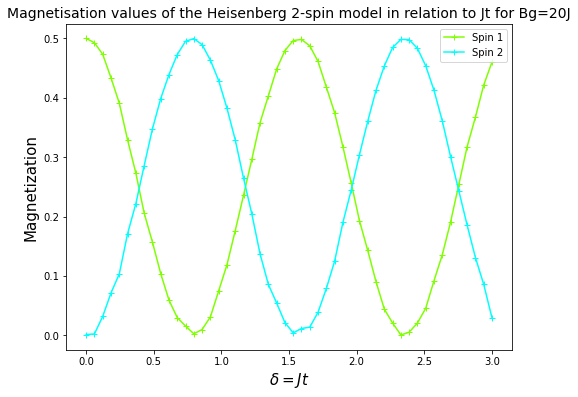

In [17]:
plt.figure(figsize = (8,6))

plt.plot(delta, m1, '-+', color = 'chartreuse')
plt.plot(delta, m2, '-+', color = 'cyan')
#plt.plot(delta, m12, '-+', color = 'pink')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('Magnetization', fontsize=15)
plt.title('Magnetisation values of the Heisenberg 2-spin model in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Spin 1', 'Spin 2'], loc = 'upper right')
#plt.grid()
plt.show()

Measures of correlation functions

**Cxx(t), Cyy(t), Czz(t)**

In [18]:
xx_real = list()
xx_im = list()
yy_real = list()
yy_im = list()
zz_real = list()
zz_im = list()

for i in delta:
    cx = corr_fct(20, 1, i, 'x', 'x')
    xx_real.append(cx.real)
    xx_im.append(cx.imag)
    
    cy = corr_fct(20, 1, i, 'y', 'y')
    yy_real.append(cy.real)
    yy_im.append(cy.imag)
    
    cz = corr_fct(20, 1, i, 'z', 'z')
    zz_real.append(cz.real)
    zz_im.append(cz.imag)

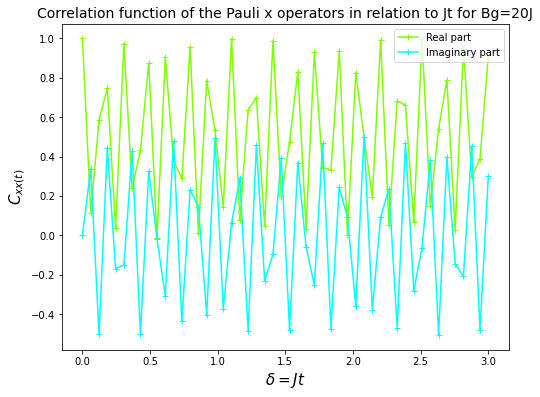

In [19]:
plt.figure(figsize = (8,6))

plt.plot(delta, xx_real, '-+', color = 'chartreuse')
plt.plot(delta, xx_im, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$C_{xx(t)}$', fontsize=15)
plt.title('Correlation function of the Pauli x operators in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Real part', 'Imaginary part'], loc = 'upper right')
#plt.grid()
plt.show()

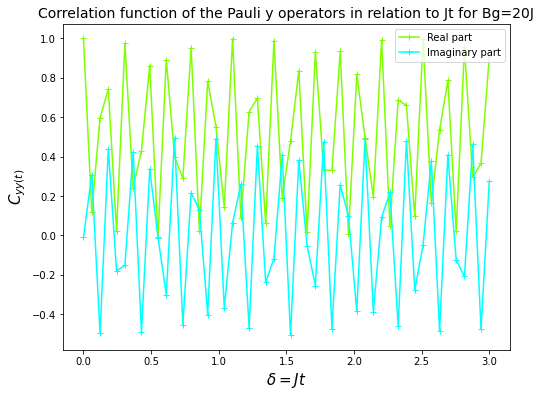

In [20]:
plt.figure(figsize = (8,6))

plt.plot(delta, yy_real, '-+', color = 'chartreuse')
plt.plot(delta, yy_im, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$C_{yy(t)}$', fontsize=15)
plt.title('Correlation function of the Pauli y operators in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Real part', 'Imaginary part'], loc = 'upper right')
#plt.grid()
plt.show()

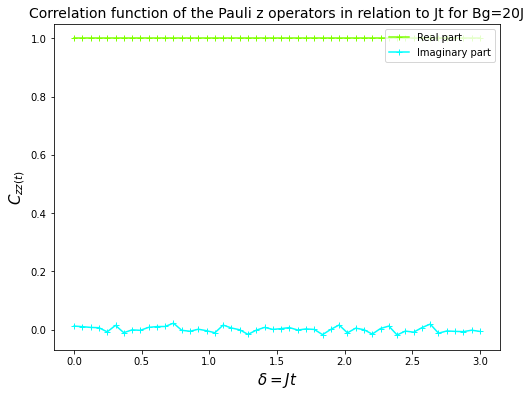

In [21]:
plt.figure(figsize = (8,6))

plt.plot(delta, zz_real, '-+', color = 'chartreuse')
plt.plot(delta, zz_im, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$C_{zz(t)}$', fontsize=15)
plt.title('Correlation function of the Pauli z operators in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Real part', 'Imaginary part'], loc = 'upper right')
#plt.grid()
plt.show()

**Cxy(t) and Cyx(t)**

In [22]:
xy_real = list()
xy_im = list()
yx_real = list()
yx_im = list()

for i in delta:
    cxy = corr_fct(20, 1, i, 'x', 'y')
    xy_real.append(cxy.real)
    xy_im.append(cxy.imag)
    
    cyx = corr_fct(20, 1, i, 'y', 'x')
    yx_real.append(cyx.real)
    yx_im.append(cyx.imag)

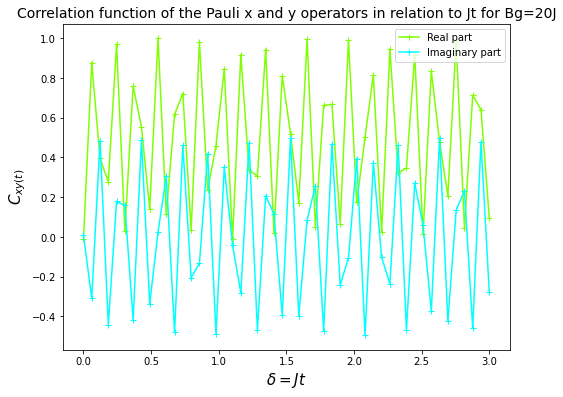

In [23]:
plt.figure(figsize = (8,6))

plt.plot(delta, xy_real, '-+', color = 'chartreuse')
plt.plot(delta, xy_im, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$C_{xy(t)}$', fontsize=15)
plt.title('Correlation function of the Pauli x and y operators in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Real part', 'Imaginary part'], loc = 'upper right')
#plt.grid()
plt.show()

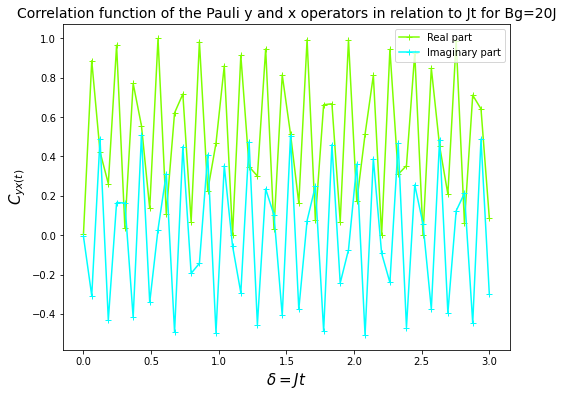

In [24]:
plt.figure(figsize = (8,6))

plt.plot(delta, yx_real, '-+', color = 'chartreuse')
plt.plot(delta, yx_im, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$C_{yx(t)}$', fontsize=15)
plt.title('Correlation function of the Pauli y and x operators in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Real part', 'Imaginary part'], loc = 'upper right')
#plt.grid()
plt.show()

**Cxz(t), Cyz(t)**

In [25]:
xz_real = list()
xz_im = list()
yz_real = list()
yz_im = list()

for i in delta:
    cxz = corr_fct(20, 1, i, 'x', 'z')
    xz_real.append(cxz.real)
    xz_im.append(cxz.imag)
    
    cyz = corr_fct(20, 1, i, 'y', 'z')
    yz_real.append(cyz.real)
    yz_im.append(cyz.imag)

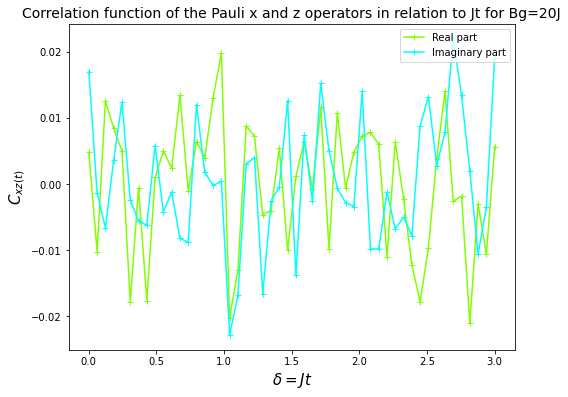

In [26]:
plt.figure(figsize = (8,6))

plt.plot(delta, xz_real, '-+', color = 'chartreuse')
plt.plot(delta, xz_im, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$C_{xz(t)}$', fontsize=15)
plt.title('Correlation function of the Pauli x and z operators in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Real part', 'Imaginary part'], loc = 'upper right')
#plt.grid()
plt.show()

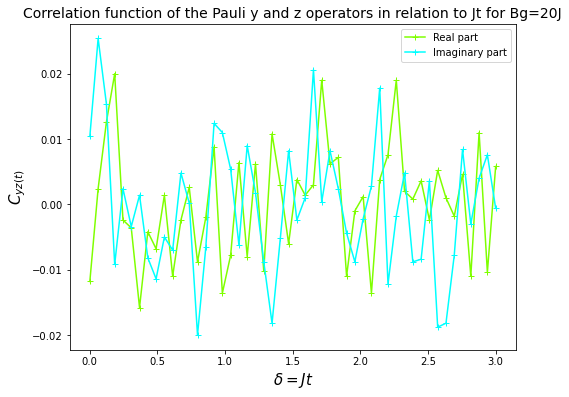

In [27]:
plt.figure(figsize = (8,6))

plt.plot(delta, yz_real, '-+', color = 'chartreuse')
plt.plot(delta, yz_im, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$C_{yz(t)}$', fontsize=15)
plt.title('Correlation function of the Pauli y and z operators in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Real part', 'Imaginary part'], loc = 'upper right')
#plt.grid()
plt.show()

# **3-spin observables**

**Correlation function**

In [28]:
#n is the number of trotterization steps
def corr_3spin(Bg, J, t, n, i, j, alpha, beta, real):

    qc = QuantumCircuit(4,1)
    
    #Initialisation to the ground stat Psi = |111>
    qc.x(0)
    qc.x(1)
    qc.x(2)
    
    #Initialization of the ancilla qubit to |+>
    qc.h(3)
    qc.barrier()
    
    #W function on qubit i
    if alpha == 'x':
        qc.cx(3,i-1)
    if alpha == 'y':
        qc.cy(3,i-1)
    if alpha == 'z':
        qc.cz(3,i-1)
   
    qc.x(3)
    qc.barrier()
        
    #Hamiltonian of non-interacting spins    
    h1(qc, 3, Bg, t)
    qc.barrier()
    
    #Hamiltonian of interacting spins with trotterization
    for i in range(n):
        h_int(qc, 0,1, J, t, n=i+1)
        h_int(qc, 1,2, J, t, n=i+1)
        qc.barrier()
    
    #V(t) function on qubit j
    if beta == 'x':
        qc.cx(3,j-1)
    if beta == 'y':
        qc.cy(3,j-1)
    if beta == 'z':
        qc.cz(3,j-1)
        
    #Final step, get the real of the imaginary function
    qc.x(3)
    qc.barrier()
    
    if real:
        qc.h(3)
    else :
        qc.sdg(3)
        qc.h(3)
    
    qc.measure(3,0)
    
    results = execute(qc, backend=backend1, shots=shots).result()
    answer = results.get_counts()
    
    answer.setdefault('1')
    if answer['1'] is None:
        answer['1'] = 0
    
    answer.setdefault('0')
    if answer['0'] is None:
        answer['0'] = 0
    
    result = answer['0']/(answer['0']+answer['1'])*1 + answer['1']/(answer['0']+answer['1'])*(-1)
    
    return result
    

Verifications of the function

In [29]:
'''Bg=20
J=1
t=2 
n=5
i=3 
j=2 
alpha='y'
beta= 'y'
real= False

qc = QuantumCircuit(4,1)
    
    #Initialisation to the ground stat Psi = |100>
qc.x(0)
    
    #Initialization of the ancilla qubit to |+>
qc.h(3)
qc.barrier()
    
    #W function on qubit i
if alpha == 'x':
    qc.cx(3,i-1)
if alpha == 'y':
    qc.cy(3,i-1)
if alpha == 'z':
    qc.cz(3,i-1)
   
qc.x(3)
qc.barrier()
        
    #Hamiltonian of non-interacting spins    
h1(qc, 3, Bg, t)
qc.barrier()
    
    #Hamiltonian of interacting spins with trotterization
for i in range(n):
    h_int(qc, 0,1, J, t, n=i+1)
    h_int(qc, 1,2, J, t, n=i+1)
    qc.barrier()
    
    #V(t) function on qubit j
if beta == 'x':
    qc.cx(3,j-1)
if beta == 'y':
    qc.cy(3,j-1)
if beta == 'z':
    qc.cz(3,j-1)
        
    #Final step, get the real of the imaginary function
qc.x(3)
qc.barrier()
    
if real:
    qc.h(3)
else :
    qc.sdg(3)
    qc.h(3)
    
qc.measure(3,0)'''
print('')

In [30]:
re_11_xx = list()

for d in delta:
    c = corr_3spin(Bg=3, J=1, t=d, n=5, i=1, j=1, alpha='x', beta='x', real=True)
    re_11_xx.append(c)

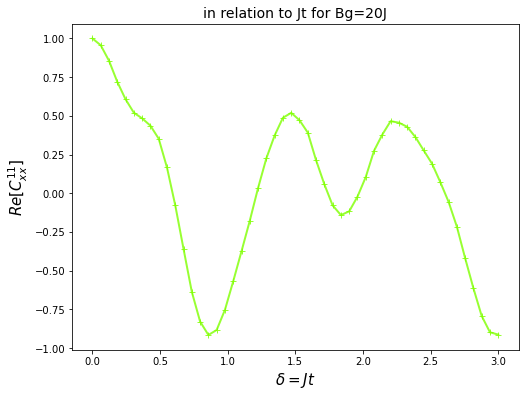

In [31]:
plt.figure(figsize = (8,6))

plt.plot(delta, re_11_xx, '-+', color = 'chartreuse', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$Re[C^{11}_{xx}]$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
#plt.grid()
plt.show()

In [32]:
im_11_xx = list()

for d in delta:
    c = corr_3spin(Bg=20, J=1, t=d, n=5, i=1, j=1, alpha='x', beta='x', real=False)
    im_11_xx.append(c)

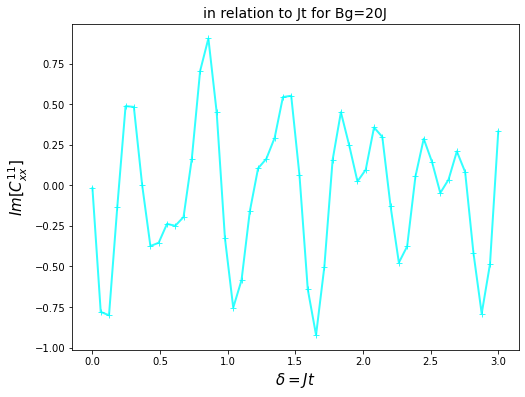

In [33]:
plt.figure(figsize = (8,6))

plt.plot(delta, im_11_xx, '-+', color = 'cyan', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$Im[C^{11}_{xx}]$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
#plt.grid()
plt.show()

In [34]:
re_21_xx = list()

for d in delta:
    c = corr_3spin(Bg=20, J=1, t=d, n=5, i=2, j=1, alpha='x', beta='x', real=True)
    re_21_xx.append(c)

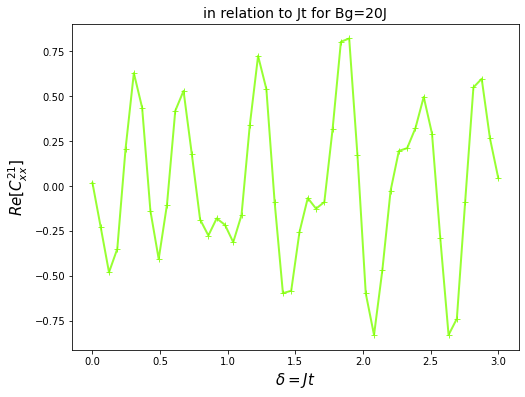

In [35]:
plt.figure(figsize = (8,6))

plt.plot(delta, re_21_xx, '-+', color = 'chartreuse', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$Re[C^{21}_{xx}]$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
#plt.grid()
plt.show()

In [36]:
im_21_xx = list()

for d in delta:
    c = corr_3spin(Bg=20, J=1, t=d, n=5, i=2, j=1, alpha='x', beta='x', real=True)
    im_21_xx.append(c)

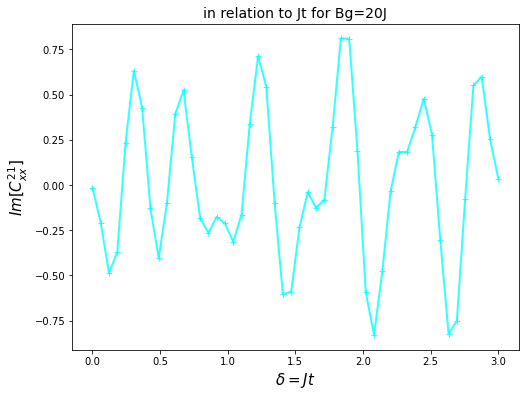

In [37]:
plt.figure(figsize = (8,6))

plt.plot(delta, im_21_xx, '-+', color = 'cyan', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$Im[C^{21}_{xx}]$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
#plt.grid()
plt.show()

In [38]:
re_31_xx = list()

for d in delta:
    c = corr_3spin(Bg=20, J=1, t=d, n=5, i=3, j=1, alpha='x', beta='x', real=True)
    re_31_xx.append(c)

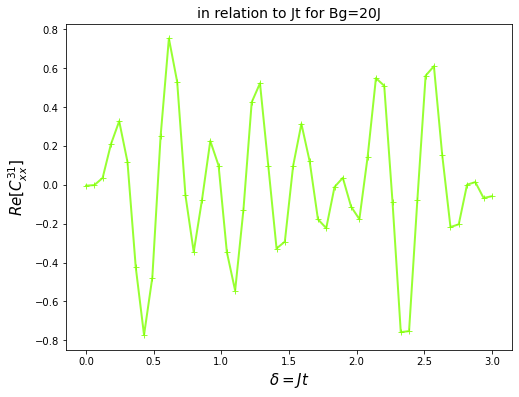

In [39]:
plt.figure(figsize = (8,6))

plt.plot(delta, re_31_xx, '-+', color = 'chartreuse', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$Re[C^{31}_{xx}]$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
#plt.grid()
plt.show()

In [40]:
im_31_xx = list()

for d in delta:
    c = corr_3spin(Bg=3, J=1, t=d, n=5, i=3, j=1, alpha='x', beta='x', real=False)
    im_31_xx.append(c)

Text(0.5, 1.0, 'in relation to Jt for Bg=20J')

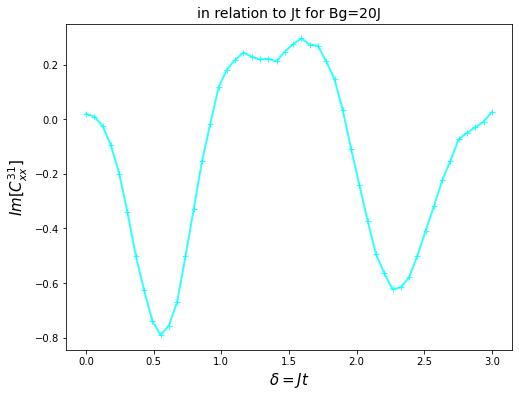

In [41]:
plt.figure(figsize = (8,6))

plt.plot(delta, im_31_xx, '-+', color = 'cyan', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$Im[C^{31}_{xx}]$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)

**Probability of measuring the ground state**

In [42]:
def proba_gs_3spin(Bg, J, t, n):

    qc = QuantumCircuit(3,3)
    
    #Initialisation to the ground stat Psi = |100>
    qc.x(2)
        
    #Hamiltonian of non-interacting spins    
    h1(qc, 3, Bg, t)
    qc.barrier()
    
    #Hamiltonian of interacting spins with trotterization
    for i in range(n):
        h_int(qc, 0,1, J, t, n=i+1)
        h_int(qc, 1,2, J, t, n=i+1)
        qc.barrier()
    
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    
    results = execute(qc, backend=backend1, shots=shots).result()
    answer = results.get_counts()
    
    #CAREFUL ON QISKIT SEARCHING FOR |100> IS "001"
    answer.setdefault('000')
    if answer['000'] is None:
        answer['000'] = 0
    answer.setdefault('001')
    if answer['001'] is None:
        answer['001'] = 0
    answer.setdefault('010')
    if answer['010'] is None:
        answer['010'] = 0
    answer.setdefault('011')
    if answer['011'] is None:
        answer['011'] = 0
    answer.setdefault('100')
    if answer['100'] is None:
        answer['100'] = 0
    answer.setdefault('101')
    if answer['101'] is None:
        answer['101'] = 0
    answer.setdefault('110')
    if answer['110'] is None:
        answer['110'] = 0
    answer.setdefault('111')
    if answer['111'] is None:
        answer['111'] = 0
    
    
    result = answer['100']/(answer['000']+answer['001']+answer['010']+answer['011']+answer['100']
                            +answer['101']+answer['110']+answer['111'])
    
    return result

In [43]:
proba = list()

for d in delta:
    p = proba_gs_3spin(Bg=20, J=1, t=d, n=5)
    proba.append(p)

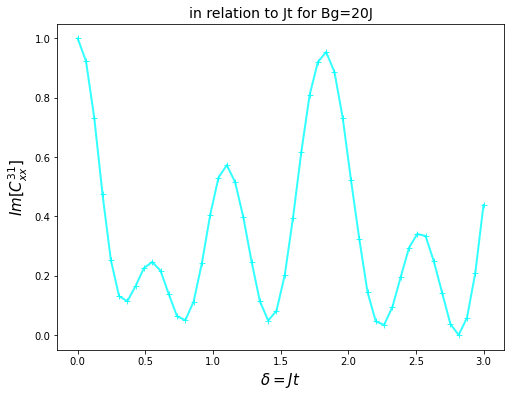

In [44]:
plt.figure(figsize = (8,6))

plt.plot(delta, proba, '-+', color = 'cyan', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$Im[C^{31}_{xx}]$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
#plt.grid()
plt.show()

**Individual magnetization of the spins**

In [45]:
def magnetization_3spin(i, Bg, j, t, n):
    
    qc = QuantumCircuit(3,1)
    
    #Initialisation of the state
    qc.x(0)
    qc.barrier()
    
    h1(qc, 3, Bg, t)
    qc.barrier()
    
    for u in range(n):
        h_int(qc, 0,1, j, t, n=u+1)
        h_int(qc, 1,2, j, t, n=u+1)
        qc.barrier()

    qc.measure(i,0)
    
    results = execute(qc, backend=backend1, shots=shots).result()
    answer = results.get_counts()
    
    answer.setdefault('1')
    if answer['1'] is None:
        answer['1'] = 0
    
    answer.setdefault('0')
    if answer['0'] is None:
        answer['0'] = 0

    spin_magn = answer['0']/(answer['0']+answer['1'])*1 + answer['1']/(answer['0']+answer['1'])*(-1)
    
    return spin_magn/2

In [46]:
n1 = list()
n2 = list()
n3 = list()

for i in delta:
    n1.append(magnetization_3spin(i=0, Bg=20, j=1, t=i, n=5))
    
for i in delta:
    n2.append(magnetization_3spin(1, Bg=20, j=1, t=i, n=5))
    
for i in delta:
    n3.append(magnetization_3spin(2, Bg=20, j=1, t=i, n=5))

In [47]:
n123_ = list(map(operator.add, n1,n2))
n123 = list(map(operator.add, n123_, n3))

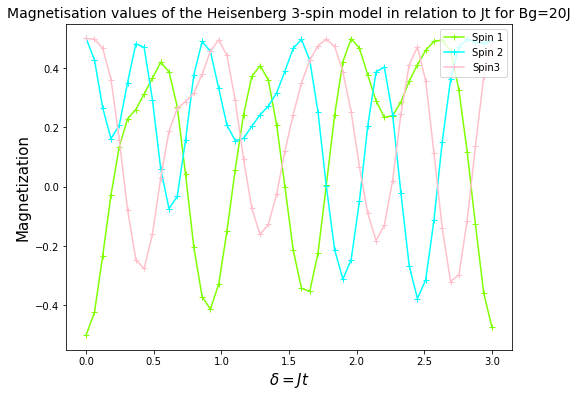

In [48]:
plt.figure(figsize = (8,6))

plt.plot(delta, n1, '-+', color = 'chartreuse')
plt.plot(delta, n2, '-+', color = 'cyan')
plt.plot(delta, n3, '-+', color = 'pink')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('Magnetization', fontsize=15)
plt.title('Magnetisation values of the Heisenberg 3-spin model in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['Spin 1', 'Spin 2', 'Spin3'], loc = 'upper right')
#plt.grid()
plt.show()

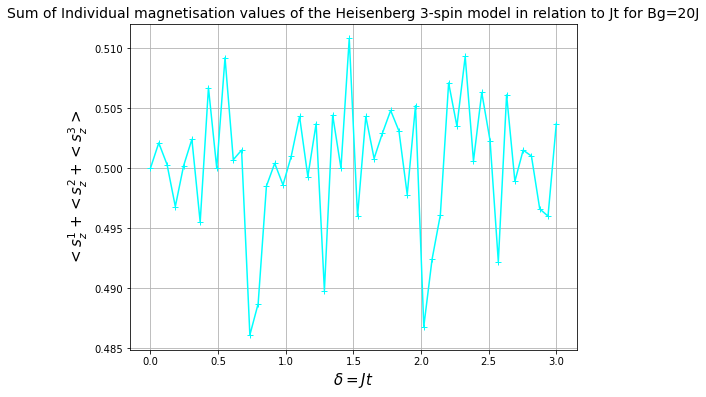

In [49]:
plt.figure(figsize = (8,6))

plt.plot(delta, n123, '-+', color = 'cyan')
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$<s_z^{1}+<s_z^{2}+<s_z^{3}>$', fontsize=15)
plt.title('Sum of Individual magnetisation values of the Heisenberg 3-spin model in relation to Jt for Bg=20J', fontsize=14)
plt.grid()
plt.show()

# Question 4. Run the simulation with the QASM simulator including noise and study how rapidly the quality of the solution deteriorates as a function of the time interval that is being simulated. This is done by computing the fidelity of the solution.

In [50]:
from qiskit.providers.aer.noise import NoiseModel
import qiskit.quantum_info as qi

provider         = IBMQ.load_account()

backend         = provider.get_backend('ibmq_manila')
noise_model      = NoiseModel.from_backend(backend)
simulator        = Aer.get_backend('qasm_simulator')

In [51]:
def statevector(answer, s):
    p = []
    
    if s == 2:
        answer.setdefault('00 00')
        if answer['00 00'] is None:
            answer['00 00'] = 0
        answer.setdefault('01 00')
        if answer['01 00'] is None:
            answer['01 00'] = 0
        answer.setdefault('10 00')
        if answer['10 00'] is None:
            answer['10 00'] = 0
        answer.setdefault('11 00')
        if answer['11 00'] is None:
            answer['11 00'] = 0
        
        tot = answer['00 00'] + answer['01 00'] + answer['10 00'] + answer['11 00']
        p.append(sqrt(answer['00 00']/tot))
        p.append(sqrt(answer['01 00']/tot))
        p.append(sqrt(answer['10 00']/tot))
        p.append(sqrt(answer['11 00']/tot))
   
    
    if s == 3:
        answer.setdefault('000 000')
        if answer['000 000'] is None:
            answer['000 000'] = 0
        answer.setdefault('001 000')
        if answer['001 000'] is None:
            answer['001 000'] = 0
        answer.setdefault('010 000')
        if answer['010 000'] is None:
            answer['010 000'] = 0
        answer.setdefault('011 000')
        if answer['011 000'] is None:
            answer['011 000'] = 0
        answer.setdefault('100 000')
        if answer['100 000'] is None:
            answer['100 000'] = 0
        answer.setdefault('101 000')
        if answer['101 000'] is None:
            answer['101 000'] = 0
        answer.setdefault('110 000')
        if answer['110 000'] is None:
            answer['110 000'] = 0
        answer.setdefault('111 000')
        if answer['111 000'] is None:
            answer['111 000'] = 0
            
        tot = answer['000 000'] + answer['001 000'] + answer['010 000'] + answer['011 000'] + answer['100 000'] + answer['101 000'] + answer['110 000'] + answer['111 000']
        p.append(sqrt(answer['000 000']/tot))
        p.append(sqrt(answer['001 000']/tot))
        p.append(sqrt(answer['010 000']/tot))
        p.append(sqrt(answer['011 000']/tot))
        p.append(sqrt(answer['100 000']/tot))
        p.append(sqrt(answer['101 000']/tot))
        p.append(sqrt(answer['110 000']/tot))
        p.append(sqrt(answer['111 000']/tot))
        
        
    return p

In [52]:
#Computation of the exact density matrix
n=5
qc = QuantumCircuit(3,3)

#Initialisation of the state
qc.x(0)
qc.barrier()
    
h1(qc, 3, Bg=20, t=2)
qc.barrier()
    
for u in range(n):
    h_int(qc, 0,1, j=1, t=2, n=u+1)
    h_int(qc, 1,2, j=1, t=2, n=u+1)

In [53]:
rho_e = qi.DensityMatrix.from_instruction(qc)
rho_e.draw('latex', prefix='\\rho_{exact} = ')

<IPython.core.display.Latex object>

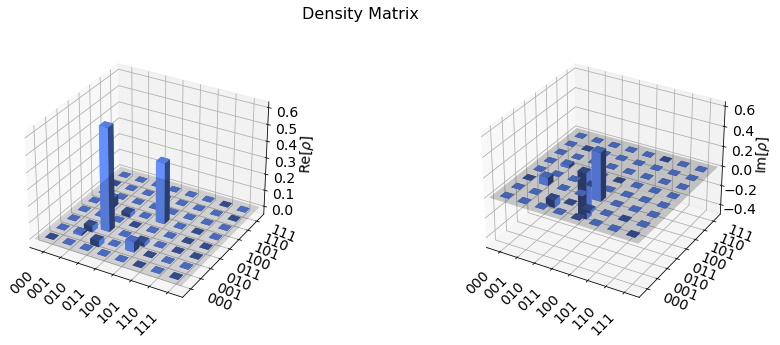

In [54]:
plot_state_city(rho_e.data, title='Density Matrix')

In [55]:
qc.measure_all()
#qc.draw('mpl')

In [56]:
results = execute(qc, backend=simulator, shots=2048, noise_model = noise_model, 
                  method='density_matrix').result() 
answer = results.get_counts()

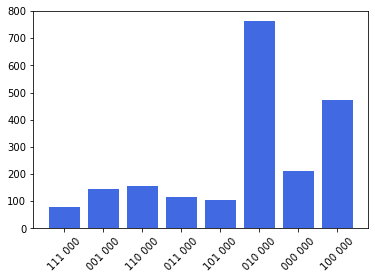

In [57]:
#METTRE LÉGENDE BLABLA
plt.suptitle("")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.xticks(rotation=45)
plt.show()

In [58]:
p = statevector(answer, 3)
    
qc_n = QuantumCircuit(3)
qc_n.initialize(p)

In [59]:
rho_n = qi.DensityMatrix.from_instruction(qc_n)
rho_n.draw('latex', prefix='\\rho_{noise} = ')

<IPython.core.display.Latex object>

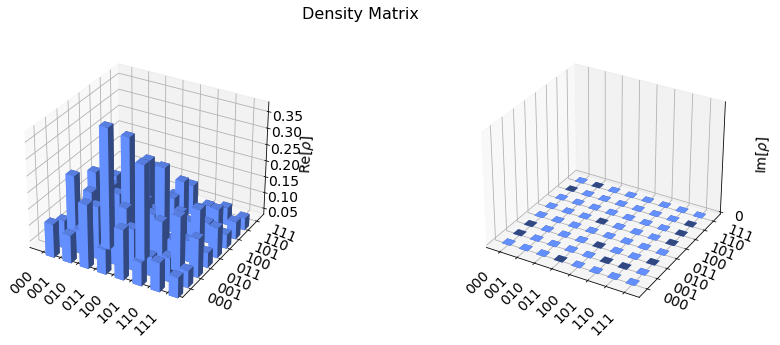

In [60]:
plot_state_city(rho_n.data, title='Density Matrix')

In [61]:
fid = qi.state_fidelity(rho_e, rho_n)
fid

0.30566127742616017

In [62]:
def fidelity(s, Bg, j, t, n):
    qc = QuantumCircuit(s,s)

    #Initialisation of the state
    #qc.x(0)
    #qc.barrier()
    
    h1(qc, s, Bg, t)
    qc.barrier()
    
    if s == 2:
        h_int(qc2, 0,1, j, t, n=1)
    else :     
        for u in range(n):
            h_int(qc, 0,1, j, t, n=u+1)
            h_int(qc, 1,2, j, t, n=u+1)
    
    #Density matrix of the exact state
    rho_e = qi.DensityMatrix.from_instruction(qc)
    
    qc.measure_all()
    
    results = execute(qc, backend=simulator, shots=2048, noise_model = noise_model).result() 
    answer = results.get_counts()
    
    p = statevector(answer, s)
    
    qc_n = QuantumCircuit(s)
    qc_n.initialize(p)

    rho_n = qi.DensityMatrix.from_instruction(qc_n)
    
    fid = qi.state_fidelity(rho_e, rho_n)
    
    return fid

**Calculate the fidelity in function of the time for 2 spin system**

In [63]:
delta2 = np.linspace(0,60,50)

In [64]:
fid = list()

for u in delta2:
    fid.append(fidelity(2, 20, 1, u, 5))

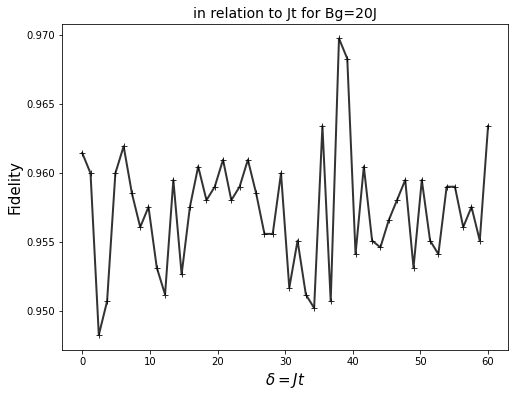

In [65]:
plt.figure(figsize = (8,6))

plt.plot(delta2, fid, '-+', color = 'black', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('Fidelity', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
#plt.grid()
plt.show()

**Fidelity for 3-spin system**

In [66]:
fid1 = list()
fid2 = list()
fid3 = list()

for u in delta:
    fid1.append(fidelity(3, 20, 1, u, 5))
    fid2.append(fidelity(3, 20, 1, u, 10))
    fid3.append(fidelity(3, 20, 1, u, 20))

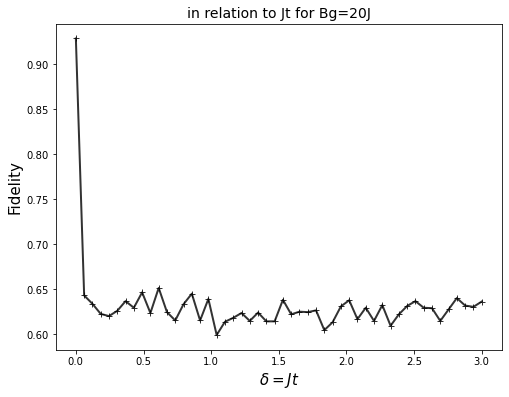

In [67]:
plt.figure(figsize = (8,6))

plt.plot(delta, fid1, '-+', color = 'black', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('Fidelity', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
plt.show()

# Question 5. Discuss the origin of errors and in particular study the relative importance of the finite time step error (called Suzuki-Trotter error) and of the errors originating from the quantum hardware itself.

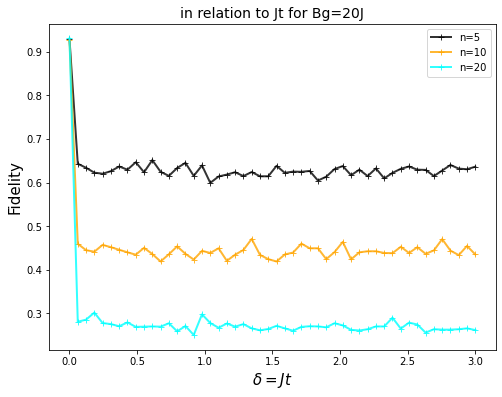

In [68]:
plt.figure(figsize = (8,6))

plt.plot(delta, fid1, '-+', color = 'black', alpha=0.8, linewidth=2)
plt.plot(delta, fid2, '-+', color = 'orange', alpha=0.8, linewidth=2)
plt.plot(delta, fid3, '-+', color = 'cyan', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('Fidelity', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['n=5', 'n=10', 'n=20'])
plt.show()

In [69]:
#Magnetization of one spin on hardware without noise for different trotterization

m5 = list()
m10 = list()
m20 = list()

for i in delta:
    m5.append(magnetization_3spin(i=0, Bg=20, j=1, t=i, n=5))
for i in delta:
    m10.append(magnetization_3spin(i=0, Bg=20, j=1, t=i, n=10))
for i in delta:
    m20.append(magnetization_3spin(i=0, Bg=20, j=1, t=i, n=20))

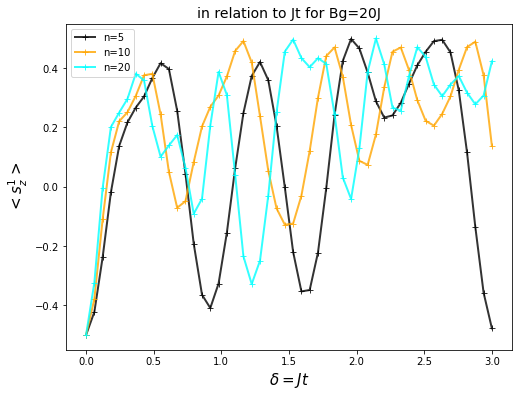

In [70]:
plt.figure(figsize = (8,6))

plt.plot(delta, m5, '-+', color = 'black', alpha=0.8, linewidth=2)
plt.plot(delta, m10, '-+', color = 'orange', alpha=0.8, linewidth=2)
plt.plot(delta, m20, '-+', color = 'cyan', alpha=0.8, linewidth=2)
plt.xlabel('$\delta = Jt$', fontsize=15)
plt.ylabel('$<s_z^{1}>$', fontsize=15)
plt.title('in relation to Jt for Bg=20J', fontsize=14)
plt.legend(['n=5', 'n=10', 'n=20'])
plt.show()